Benchmarking results files must be placed in the following manner:

```
- benchmarking-results-for-visualizations
  - json-accuracy
    - llm-img2json
      - model
        - llm-img2json_<cleaning_method>_<time_str>.csv
        - ...
    - llm-txt2json
      - model
        - llm-txt2json_<cleaning_method>_<time_str>.csv
        - ...
  - txt-accuracy
    - llm-img2txt
      - model
        - <cleaning_method>_<time_str>.csv
        - ...
    - ocr-img2txt
      - ...
    - ocr-llm-img2txt
      - ...
```    

# Open multiple results files using Pandas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob
import math

ROOT_DIR = Path.cwd().parent.parent

# For reference only
TXT_PARENT_DIR = ROOT_DIR / 'benchmarking-results-for-visualizations' / 'txt-accuracy'
TXT_SUB_DIRS = ['llm-img2txt', 'ocr-img2txt', 'ocr-llm-img2txt']

JSON_PARENT_DIR = ROOT_DIR / 'benchmarking-results-for-visualizations' / 'json-accuracy'
JSON_SUB_DIRS = ['llm-img2json', 'llm-txt2json']

# The columns of the dataframe that doesn't correspond to the columns
DF_INFO_COLS = ['sub_dir', 'cleaning_method', 'time_str', 'doc', 'metric']

def process_dfs(df: pd.DataFrame, sub_dir: str, filename: str) -> pd.DataFrame:
    """
    Returns a new dataframe with the following operations applied:
    - Adds the column `sub_dir`, which is the subdirectory the file is located in (i.e. img2json) found from the sub_dir parameter.
    - Adds the column `cleaning_method`, which contains either 'normalized', 'nonorm', or 'fuzzy' found from the cleaning_method parameter.
    - Adds the column `time_str`, which is a string representing the time of file creation found from the name parameter.
    - Splits the previously-unnamed column into a `doc` and `metric` column
    """
    old_cols = list(df.columns)
    new_cols = ["sub_dir", "cleaning_method", "time_str", "doc", "metric"] + old_cols

    # Filename format: assume the following; others are invalid
    # - llm-img2json_<cleaning_method>_<time_str>.csv
    # - llm-txt2json_<cleaning_method>_<time_str>.csv
    # - <cleaning_method>_<time_str>.csv

    filename_split = filename.split("_")
    cleaning_method = "_".join(filename_split[:-2]).removeprefix("llm-img2json_").removeprefix("llm-txt2json_")
    time_str = "_".join(filename_split[-2:]).removesuffix(".csv")

    processed_df = df.copy()
    processed_df["sub_dir"] = sub_dir
    processed_df["cleaning_method"] = cleaning_method
    processed_df["time_str"] = time_str
    processed_df["doc"] = processed_df["Unnamed: 0"].apply(lambda x: (x.split(":")[0]))
    processed_df["metric"] = processed_df["Unnamed: 0"].apply(lambda x: ":".join(x.split(":")[1:]))
    processed_df = processed_df[new_cols]
    processed_df = processed_df.drop(columns="Unnamed: 0")

    return processed_df


def open_benchmarking_results_folder(parent_dir: Path, sub_dir: str) -> pd.DataFrame:
    """
    Opens all of the benchmarking results within a single directory following the specified parameters.
    `search_pattern` is handled using glob.

    Returns a list with dataframes.
    """

    file_paths = (parent_dir / sub_dir).glob('*.csv')
    dataframes = [
        process_dfs(
            pd.read_csv(parent_dir / sub_dir / path), sub_dir, path.name
        ) for path in file_paths
    ]

    combined = pd.concat(dataframes, ignore_index=True)
    return combined


def open_all_benchmarking_results(parent_dir: Path, sub_dirs: list[str]):
    """
    Opens all of the benchmarking results for either text or JSON output.

    Returns a combined dataframe.
    """
    dataframes = [
        open_benchmarking_results_folder(parent_dir, sub_dir) for sub_dir in sub_dirs
    ]
    combined = pd.concat(dataframes, ignore_index=True)
    return combined


txt_bm = open_all_benchmarking_results(TXT_PARENT_DIR, TXT_SUB_DIRS)
json_bm = open_all_benchmarking_results(JSON_PARENT_DIR, JSON_SUB_DIRS)

## Verify all the documents are opened correctly by listing uniques:

In [2]:
def uniques(df: pd.DataFrame):
    ret = {}
    for col in DF_INFO_COLS:
        ret[col] = df[col].unique()
    return ret

def print_bm_info(df: pd.DataFrame):
    df_uniques = uniques(df)
    print(df_uniques)
    print(f"Pages count (including all): {len(df_uniques['doc'])}")

In [3]:
print_bm_info(txt_bm)

{'sub_dir': array(['llm-img2txt', 'ocr-img2txt', 'ocr-llm-img2txt'], dtype=object), 'cleaning_method': array(['nonorm', 'normalized'], dtype=object), 'time_str': array(['2025-07-17_13-13-11-muhammad2', '2025-07-16_12-01-57-tim1',
       '_amelia1', '_amelia2', '2025-07-16_12-04-59-tim2'], dtype=object), 'doc': array(['kbaa-p003', 'kbaa-p039', 'kbaa-p005', 'kbaa-p011', 'kbaa-p010',
       'kbaa-p004', 'kbaa-p038', 'kbaa-p012', 'kbaa-p006', 'kbaa-p007',
       'kbaa-p060', 'kbaa-p048', 'kbaa-p100', 'kbaa-p114', 'kbaa-p115',
       'kbaa-p101', 'kbaa-p049', 'kbaa-p061', 'kbaa-p063', 'kbaa-p062',
       'kbaa-p066', 'kbaa-p072', 'kbaa-p106', 'kbaa-p107', 'kbaa-p113',
       'kbaa-p073', 'kbaa-p067', 'kbaa-p059', 'kbaa-p071', 'kbaa-p065',
       'kbaa-p064', 'kbaa-p070', 'kbaa-p058', 'kbaa-p069', 'kbaa-p096',
       'kbaa-p121', 'kbaa-p068', 'kbaa-p043', 'kbaa-p124', 'kbaa-p119',
       'kbaa-p009', 'kbaa-p008', 'kbaa-p151', '__ALL__'], dtype=object), 'metric': array(['dist_char', 'doc_len'

In [4]:
print_bm_info(json_bm)

{'sub_dir': array(['llm-img2json', 'llm-txt2json'], dtype=object), 'cleaning_method': array(['fuzzy', 'normalized', 'nonorm'], dtype=object), 'time_str': array(['2025-07-16_12-02-30-tim1', '_amelia2', '_amelia1',
       '2025-07-16_12-07-24-tim2', '2025-07-17_13-13-21-muhammad2'],
      dtype=object), 'doc': array(['kbaa-p114', 'kbaa-p006', 'kbaa-p010', 'kbaa-p067', 'kbaa-p071',
       'kbaa-p070', 'kbaa-p066', 'kbaa-p119', 'kbaa-p011', 'kbaa-p007',
       'kbaa-p115', 'kbaa-p061', 'kbaa-p124', 'kbaa-p113', 'kbaa-p060',
       'kbaa-p063', 'kbaa-p059', 'kbaa-p096', 'kbaa-p038', 'kbaa-p043',
       'kbaa-p106', 'kbaa-p151', 'kbaa-p003', 'kbaa-p107', 'kbaa-p039',
       'kbaa-p058', 'kbaa-p062', 'kbaa-p069', 'kbaa-p100', 'kbaa-p012',
       'kbaa-p004', 'kbaa-p073', 'kbaa-p065', 'kbaa-p049', 'kbaa-p008',
       'kbaa-p009', 'kbaa-p048', 'kbaa-p121', 'kbaa-p064', 'kbaa-p072',
       'kbaa-p005', 'kbaa-p101', 'kbaa-p068', '__ALL__'], dtype=object), 'metric': array(['__COL__:lastname', '__C

# Text benchmarking results

In [5]:
txt_bm

,sub_dir,cleaning_method,time_str,doc,metric,gemini-2.5-flash,gpt-4o,pytesseract
0,llm-img2txt,nonorm,2025-07-17_13-13-11-muhammad2,kbaa-p003,dist_char,20.000000,10.000000,NaN
1,llm-img2txt,nonorm,2025-07-17_13-13-11-muhammad2,kbaa-p003,doc_len,2894.000000,2894.000000,NaN
2,llm-img2txt,nonorm,2025-07-17_13-13-11-muhammad2,kbaa-p003,cer_pct,0.691085,0.345543,NaN
3,llm-img2txt,nonorm,2025-07-17_13-13-11-muhammad2,kbaa-p003,wer_pct,3.311258,1.545254,NaN
4,llm-img2txt,nonorm,2025-07-17_13-13-11-muhammad2,kbaa-p003,token_sort_ratio,98.580269,99.854387,NaN
...,...,...,...,...,...,...,...,...
6595,ocr-llm-img2txt,normalized,2025-07-17_13-13-11-muhammad2,__ALL__,dist_char,5159.000000,1986.000000,NaN
6596,ocr-llm-img2txt,normalized,2025-07-17_13-13-11-muhammad2,__ALL__,doc_len,141477.000000,141477.000000,NaN
6597,ocr-llm-img2txt,normalized,2025-07-17_13-13-11-muhammad2,__ALL__,cer_pct,3.646529,1.403762,NaN
6598,ocr-llm-img2txt,normalized,2025-07-17_13-13-11-muhammad2,__ALL__,wer_pct,4.757374,1.462892,NaN


## Move pytesseract results alongside LLM results

In [6]:
# Split txt results to (llm-img2txt + ocr-llm-img2txt) and (ocr-img2txt)
llm_txt = txt_bm[txt_bm['sub_dir'] != 'ocr-img2txt']
ocr_txt = txt_bm[txt_bm['sub_dir'] == 'ocr-img2txt']

# Fill in llm-img2txt columns
for index, row in llm_txt.iterrows():
    cleaning_method = row['cleaning_method']
    time_str = row['time_str']
    doc = row['doc']
    metric = row['metric']

    ocr_metric = ocr_txt.loc[
        (ocr_txt['cleaning_method'] == cleaning_method) &
        (ocr_txt['time_str'] == time_str) &
        (ocr_txt['doc'] == doc) &
        (ocr_txt['metric'] == metric),
        'pytesseract'
    ]
    if not ocr_metric.empty:
        llm_txt.loc[index, 'pytesseract'] = ocr_metric.iloc[0]

llm_txt

,sub_dir,cleaning_method,time_str,doc,metric,gemini-2.5-flash,gpt-4o,pytesseract
0,llm-img2txt,nonorm,2025-07-17_13-13-11-muhammad2,kbaa-p003,dist_char,20.000000,10.000000,251.000000
1,llm-img2txt,nonorm,2025-07-17_13-13-11-muhammad2,kbaa-p003,doc_len,2894.000000,2894.000000,2894.000000
2,llm-img2txt,nonorm,2025-07-17_13-13-11-muhammad2,kbaa-p003,cer_pct,0.691085,0.345543,8.673117
3,llm-img2txt,nonorm,2025-07-17_13-13-11-muhammad2,kbaa-p003,wer_pct,3.311258,1.545254,22.958057
4,llm-img2txt,nonorm,2025-07-17_13-13-11-muhammad2,kbaa-p003,token_sort_ratio,98.580269,99.854387,93.451520
...,...,...,...,...,...,...,...,...
6595,ocr-llm-img2txt,normalized,2025-07-17_13-13-11-muhammad2,__ALL__,dist_char,5159.000000,1986.000000,9872.000000
6596,ocr-llm-img2txt,normalized,2025-07-17_13-13-11-muhammad2,__ALL__,doc_len,141477.000000,141477.000000,141477.000000
6597,ocr-llm-img2txt,normalized,2025-07-17_13-13-11-muhammad2,__ALL__,cer_pct,3.646529,1.403762,6.977813
6598,ocr-llm-img2txt,normalized,2025-07-17_13-13-11-muhammad2,__ALL__,wer_pct,4.757374,1.462892,10.708056


In [7]:
# Make sure all rows are matched to pytesseract metric:
llm_txt.isna().sum()

sub_dir             0
cleaning_method     0
time_str            0
doc                 0
metric              0
gemini-2.5-flash    0
gpt-4o              0
pytesseract         0
dtype: int64

## Calculate metrics

In [8]:
# Use for filtering entries that are for "__ALL__" documents or single documents.
txt_all_docs = llm_txt['doc'] == '__ALL__'

# Use for filtering only error rates.
txt_error_rates = (
    (llm_txt['metric'] == 'cer_pct') |
    (llm_txt['metric'] == 'wer_pct') |
    (llm_txt['metric'] == 'token_sort_ratio')
)

In [9]:
llm_txt_grouped = llm_txt[~txt_all_docs].drop(columns=['doc', 'time_str']).groupby(['sub_dir', 'cleaning_method', 'metric'])
llm_txt_grouped_mean = llm_txt_grouped.mean()
llm_txt_grouped_mean

gemini-2.5-flash  \
sub_dir         cleaning_method metric                               
llm-img2txt     nonorm          cer_pct                   5.386137   
                                dist_char               195.823256   
                                doc_len                3634.539535   
                                token_sort_ratio         98.629721   
                                wer_pct                   8.670243   
                normalized      cer_pct                   4.263303   
                                dist_char               140.381395   
                                doc_len                3296.851163   
                                token_sort_ratio         99.295457   
                                wer_pct                   5.215460   
ocr-llm-img2txt nonorm          cer_pct                   5.208904   
                                dist_char               189.079070   
                                doc_len                3634.539535   
                                token_sort_ratio         98.468161   
                                wer_pct                   7.520650   
                normalized      cer_pct                   4.032735   
                                dist_char               132.776744   
                                doc_len                3296.851163   
                                token_sort_ratio         99.142236   
                                wer_pct                   5.140685   

                                                       gpt-4o  pytesseract  
sub_dir         cleaning_method metric                                      
llm-img2txt     nonorm          cer_pct              2.404929     9.944470  
                                dist_char           88.227907   361.404651  
                                doc_len           3634.539535  3634.539535  
                                token_sort_ratio    98.596191    97.016596  
                                wer_pct              4.679370    15.535147  
                normalized      cer_pct              1.879257     7.718000  
                                dist_char           62.576744   254.646512  
                                doc_len           3296.851163  3296.851163  
                                token_sort_ratio    99.203152    98.112853  
                                wer_pct              2.344987    11.390937  
ocr-llm-img2txt nonorm          cer_pct              1.735637     9.944470  
                                dist_char           63.241860   361.404651  
                                doc_len           3634.539535  3634.539535  
                                token_sort_ratio    98.648540    97.016596  
                                wer_pct              3.994496    15.535147  
                normalized      cer_pct              1.379667     7.718000  
                                dist_char           45.665116   254.646512  
                                doc_len           3296.851163  3296.851163  
                                token_sort_ratio    99.269391    98.112853  
                                wer_pct              1.413457    11.390937

In [10]:
llm_txt_grouped_std = llm_txt_grouped.std()
llm_txt_grouped_std

gemini-2.5-flash  \
sub_dir         cleaning_method metric                               
llm-img2txt     nonorm          cer_pct                   7.655367   
                                dist_char               274.638380   
                                doc_len                 138.835568   
                                token_sort_ratio          1.040500   
                                wer_pct                   8.455326   
                normalized      cer_pct                   7.364888   
                                dist_char               237.913189   
                                doc_len                 135.530478   
                                token_sort_ratio          0.527524   
                                wer_pct                   8.405714   
ocr-llm-img2txt nonorm          cer_pct                   3.569888   
                                dist_char               128.734416   
                                doc_len                 138.835568   
                                token_sort_ratio          1.027224   
                                wer_pct                   4.235641   
                normalized      cer_pct                   2.806491   
                                dist_char                91.593507   
                                doc_len                 135.530478   
                                token_sort_ratio          0.561563   
                                wer_pct                   3.804443   

                                                      gpt-4o  pytesseract  
sub_dir         cleaning_method metric                                     
llm-img2txt     nonorm          cer_pct             2.520253     6.707440  
                                dist_char          93.612690   244.340748  
                                doc_len           138.835568   138.835568  
                                token_sort_ratio    1.035987     1.461880  
                                wer_pct             2.980676     8.027356  
                normalized      cer_pct             2.056305     6.707874  
                                dist_char          69.182627   221.933845  
                                doc_len           135.530478   135.530478  
                                token_sort_ratio    0.571809     1.220976  
                                wer_pct             2.701049     8.040918  
ocr-llm-img2txt nonorm          cer_pct             1.053626     6.707440  
                                dist_char          38.526082   244.340748  
                                doc_len           138.835568   138.835568  
                                token_sort_ratio    1.017157     1.461880  
                                wer_pct             1.801484     8.027356  
                normalized      cer_pct             0.955188     6.707874  
                                dist_char          31.600743   221.933845  
                                doc_len           135.530478   135.530478  
                                token_sort_ratio    0.473779     1.220976  
                                wer_pct             0.964280     8.040918

Note: we can also group only the "\__ALL__" results which would give us differences between each run.

# JSON benchmarking results

In [11]:
json_bm

,sub_dir,cleaning_method,time_str,doc,metric,gemini-2.5-flash,gpt-4o
0,llm-img2json,fuzzy,2025-07-16_12-02-30-tim1,kbaa-p114,__COL__:lastname,23,23
1,llm-img2json,fuzzy,2025-07-16_12-02-30-tim1,kbaa-p114,__COL__:firstname,21,22
2,llm-img2json,fuzzy,2025-07-16_12-02-30-tim1,kbaa-p114,__COL__:maidenname,23,23
3,llm-img2json,fuzzy,2025-07-16_12-02-30-tim1,kbaa-p114,__COL__:birthyear,23,23
4,llm-img2json,fuzzy,2025-07-16_12-02-30-tim1,kbaa-p114,__COL__:deathyear,23,23
...,...,...,...,...,...,...,...
25645,llm-txt2json,fuzzy,2025-07-17_13-13-21-muhammad2,kbaa-p005,__COL__:publishyear,NaN,3
25646,llm-txt2json,fuzzy,2025-07-17_13-13-21-muhammad2,kbaa-p005,__COL__:pagecount,NaN,3
25647,llm-txt2json,fuzzy,2025-07-17_13-13-21-muhammad2,kbaa-p005,__COL__:library,NaN,6
25648,llm-txt2json,fuzzy,2025-07-17_13-13-21-muhammad2,kbaa-p005,__COL__:description,NaN,2


In [12]:
json_only_all_docs = json_bm['doc'] == '__ALL__'
json_only_cols = json_bm['metric'].str.contains(r'__COL__:', regex=True)
json_only_int_results = (json_bm['metric'] != 'matches_pct') & (json_bm['metric'] != 'mismatch_bool')

Sums:

In [13]:
json_bm_int_all = json_bm[json_only_all_docs & json_only_int_results]
json_bm_int_all.loc[:,'gemini-2.5-flash'] = json_bm_int_all['gemini-2.5-flash'].astype('int')
json_bm_int_all.loc[:,'gpt-4o'] = json_bm_int_all['gpt-4o'].astype('int')
json_bm_int_all_grouped = json_bm_int_all.drop(columns=['doc', 'time_str']).groupby(['sub_dir', 'cleaning_method', 'metric'])
json_sum = json_bm_int_all_grouped.sum()
json_sum.head(25)

gemini-2.5-flash gpt-4o
sub_dir      cleaning_method metric                                      
llm-img2json fuzzy           __COL__:birthyear                3826   3096
                             __COL__:city                     3748   2982
                             __COL__:deathyear                3902   3264
                             __COL__:description              3439   2789
                             __COL__:firstname                3688   2997
                             __COL__:index                    3794   3087
                             __COL__:lastname                 3831   3238
                             __COL__:library                  3735   2635
                             __COL__:maidenname               3918   3380
                             __COL__:pagecount                3763   2971
                             __COL__:publisher                3731   2889
                             __COL__:publishyear              3762   2998
                             __COL__:title                    3637   2832
                             counted_nrows                    3981   3471
                             gt_nrows                         4408   4408
                             matches                         48774  39158
                             mismatched_dim_count               20     44
                             pred_adj_nrows                   4381   4290
                             pred_nrows                       4292   4168
                             total                           51753  45123
             nonorm          __COL__:birthyear                3826   3096
                             __COL__:city                     3718   2922
                             __COL__:deathyear                3902   3264
                             __COL__:description              3148   2439
                             __COL__:firstname                3628   2840

For JSON results, you need to first sum up each of the "__ALL__" entries. Then you need to divide specific rows by the specific values (columnwise results over "counted_nrows" to get percent matched by column, matches over "total" to get percent total cells matched, "counted_nrows" over "gt_nrows" to get percent of columns compared.)

In [14]:
# Create per-column percentages
json_col_pct = pd.DataFrame(columns=json_sum.columns, index=json_sum.index)
json_matches_pct = pd.DataFrame(columns=json_sum.columns, index=json_sum.index)
json_nrows_pct = pd.DataFrame(columns=json_sum.columns, index=json_sum.index)

for index, row in json_sum.iterrows():
    if index[2].startswith('__COL__:'):
        row_pcts = row / json_sum.loc[index[0], index[1], 'counted_nrows'] * 100
        json_col_pct.loc[index] = row_pcts
    if index[2] == 'matches':
        matches_pcts = row / json_sum.loc[index[0], index[1], 'total'] * 100
        json_matches_pct.loc[index] = matches_pcts
    if index[2] == 'counted_nrows' or index[2] == 'pred_nrows':
        nrows_pcts = row / json_sum.loc[index[0], index[1], 'gt_nrows'] * 100
        json_nrows_pct.loc[index] = nrows_pcts

json_col_pct = json_col_pct.dropna()
json_matches_pct = json_matches_pct.dropna()
json_nrows_pct = json_nrows_pct.dropna()
json_col_pct

gemini-2.5-flash     gpt-4o
sub_dir      cleaning_method metric                                         
llm-img2json fuzzy           __COL__:birthyear          96.106506  89.196197
                             __COL__:city               94.147199  85.911841
                             __COL__:deathyear          98.015574  94.036301
                             __COL__:description         86.38533  80.351484
                             __COL__:firstname           92.64004  86.343993
...                                                           ...        ...
llm-txt2json normalized      __COL__:maidenname         98.478597  98.230578
                             __COL__:pagecount          92.109335  86.729334
                             __COL__:publisher          91.206808  86.784628
                             __COL__:publishyear         91.77411  87.337573
                             __COL__:title              86.616813  81.061653

[78 rows x 2 columns]

In [15]:
json_matches_pct

gemini-2.5-flash     gpt-4o
sub_dir      cleaning_method metric                             
llm-img2json fuzzy           matches        94.243812  86.780578
             nonorm          matches        89.476939  80.770339
             normalized      matches        93.463181  85.402123
llm-txt2json fuzzy           matches         92.33943  88.907084
             nonorm          matches        88.407982  84.022033
             normalized      matches        91.766176  88.260564

In [16]:
# Note: counted_nrows is the percent of rows actually compared; pred_nrows is the percent of rows in the LLM output
json_nrows_pct

gemini-2.5-flash     gpt-4o
sub_dir      cleaning_method metric                                   
llm-img2json fuzzy           counted_nrows        90.313067  78.743194
                             pred_nrows           97.368421  94.555354
             nonorm          counted_nrows        90.313067  78.743194
                             pred_nrows           97.368421  94.555354
             normalized      counted_nrows        90.313067  78.743194
                             pred_nrows           97.368421  94.555354
llm-txt2json fuzzy           counted_nrows        87.976407  82.055354
                             pred_nrows           97.549909  96.370236
             nonorm          counted_nrows        87.976407  82.055354
                             pred_nrows           97.549909  96.370236
             normalized      counted_nrows        87.976407  82.055354
                             pred_nrows           97.549909  96.370236

# Visualizations

## Bar charts of aggregated results

In [17]:
# Utility functions for retrieving results with less typing
def results_mask(df, sub_dir, cleaning_method, metric):
    return (
        (df['sub_dir'] == sub_dir) &
        (df['cleaning_method'] == cleaning_method) &
        (df['metric'] == metric)
    )

gemini-2.5-flash    4.263303
gpt-4o              1.879257
pytesseract         7.718000
Name: (llm-img2txt, normalized, cer_pct), dtype: float64


(98.0, 100.0)

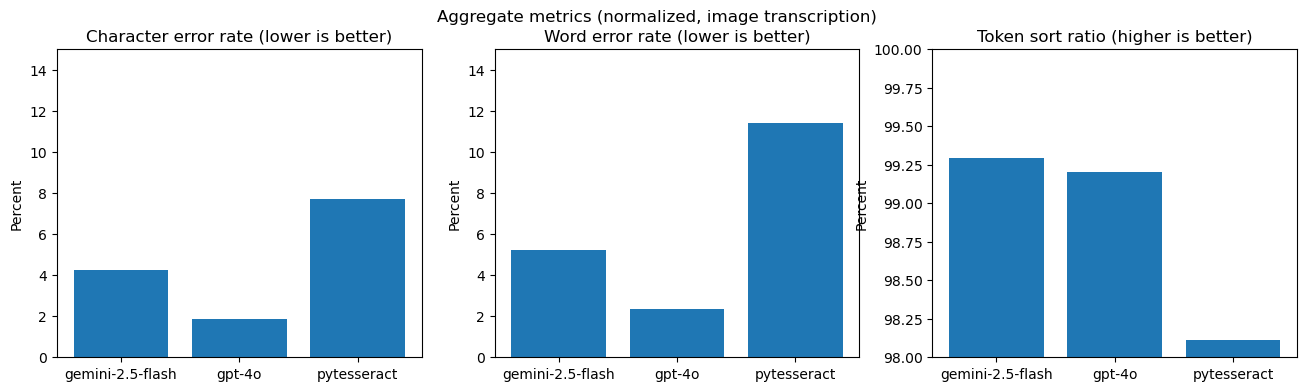

In [18]:
fig, (cer_ax, wer_ax, tsr_ax) = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

cer_pct = llm_txt_grouped_mean.loc['llm-img2txt', 'normalized', 'cer_pct']
wer_pct = llm_txt_grouped_mean.loc['llm-img2txt', 'normalized', 'wer_pct']
tsr_pct = llm_txt_grouped_mean.loc['llm-img2txt', 'normalized', 'token_sort_ratio']
models = ['gemini-2.5-flash', 'gpt-4o', 'pytesseract']

cer_std = llm_txt_grouped_std.loc['llm-img2txt', 'normalized', 'cer_pct']
wer_std = llm_txt_grouped_std.loc['llm-img2txt', 'normalized', 'wer_pct']
tsr_std = llm_txt_grouped_std.loc['llm-img2txt', 'normalized', 'token_sort_ratio']

ER_MAX = 15

print(cer_pct)

fig.suptitle('Aggregate metrics (normalized, image transcription)')

# cer_ax.errorbar(models, cer_pct, yerr=cer_std, ecolor='black', fmt='.')
cer_ax.bar(models, cer_pct)
cer_ax.set_title('Character error rate (lower is better)')
cer_ax.set_ylabel('Percent')
cer_ax.set_ylim(0, ER_MAX)

# wer_ax.errorbar(models, wer_pct, yerr=wer_std, ecolor='black', fmt='.')
wer_ax.bar(models, wer_pct)
wer_ax.set_title('Word error rate (lower is better)')
wer_ax.set_ylabel('Percent')
wer_ax.set_ylim(0, ER_MAX)

# tsr_ax.errorbar(models, tsr_pct, yerr=tsr_std, ecolor='black', fmt='.')
tsr_ax.bar(models, tsr_pct)
tsr_ax.set_title('Token sort ratio (higher is better)')
tsr_ax.set_ylabel('Percent')
tsr_ax.set_ylim(np.floor(np.min(tsr_pct)), 100)

## Histogram of error rates across individual pages

In [19]:
# Get all CER rates of individual pages
all_cer_pct = llm_txt[
    ~txt_all_docs &
    (llm_txt['metric'] == 'cer_pct') &
    (llm_txt['cleaning_method'] == 'normalized') &
    (llm_txt['sub_dir'] == 'ocr-llm-img2txt')
]
all_wer_pct = llm_txt[
    ~txt_all_docs &
    (llm_txt['metric'] == 'wer_pct') &
    (llm_txt['cleaning_method'] == 'normalized') &
    (llm_txt['sub_dir'] == 'ocr-llm-img2txt')
]

75.0


Text(0, 0.5, 'Frequency')

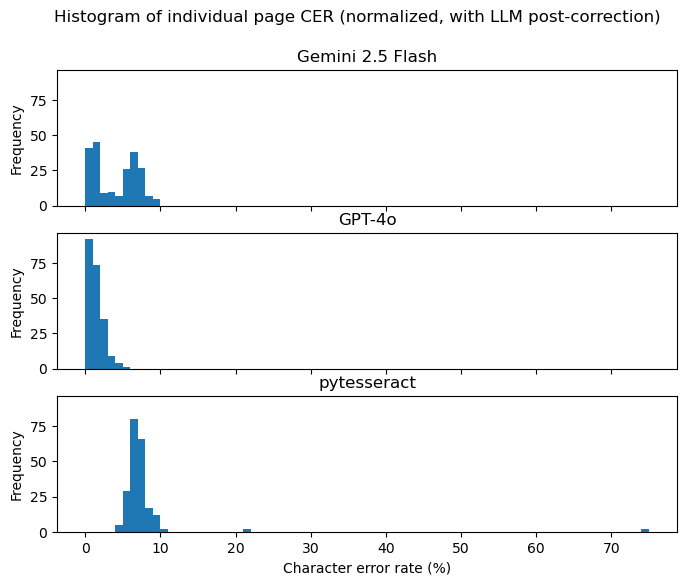

In [20]:
# Compare error rates of different models/methods
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(8, 6), sharex=True, sharey=True)
fig.suptitle('Histogram of individual page CER (normalized, with LLM post-correction)')

print(np.ceil(np.max(all_cer_pct.drop(DF_INFO_COLS, axis='columns'))))

bin_width_even = range(0, int(np.ceil(np.max(all_cer_pct.drop(DF_INFO_COLS, axis='columns'))) + 1), 1)

ax0.hist(all_cer_pct['gemini-2.5-flash'], bins=bin_width_even)
ax0.set_title('Gemini 2.5 Flash')
ax0.set_ylabel('Frequency')
ax1.hist(all_cer_pct['gpt-4o'], bins=bin_width_even)
ax1.set_title('GPT-4o')
ax1.set_ylabel('Frequency')
ax2.hist(all_cer_pct['pytesseract'], bins=bin_width_even)
ax2.set_title('pytesseract')
ax2.set_xlabel('Character error rate (%)')
ax2.set_ylabel('Frequency')

## Bar graph displaying frequencies of CER by category

In [21]:
def er_freqs_from(df):
    error_rates_only = df.drop(columns=DF_INFO_COLS)
    er_less_than_1 = (error_rates_only < 1).sum()
    er_between_1_5 = ((error_rates_only >= 1) & (error_rates_only < 5)).sum()
    er_greater_than_5 = (error_rates_only >= 5).sum()
    er_combined = pd.DataFrame({
        "error <1%": er_less_than_1,
        "1% <= error < 5%": er_between_1_5,
        "error >= 5%": er_greater_than_5
    }).transpose()
    return er_combined
cer_combined = er_freqs_from(all_cer_pct)
wer_combined = er_freqs_from(all_wer_pct)
cer_combined.head()

,gemini-2.5-flash,gpt-4o,pytesseract
error <1%,41,92,0
1% <= error < 5%,71,122,5
error >= 5%,103,1,210


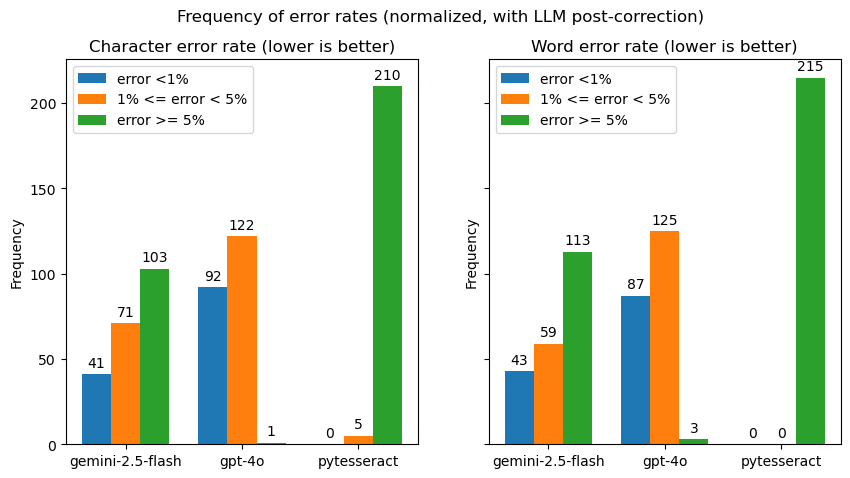

In [22]:
# Similar histogram as above, but uses separately-sized bins.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)

models = ['gemini-2.5-flash', 'gpt-4o', 'pytesseract']

fig.suptitle('Frequency of error rates (normalized, with LLM post-correction)')

# cer_ax.bar(models, cer_pct)
for ax, data, title in zip(
    axes,
    [cer_combined, wer_combined],
    ["Character error rate (lower is better)", "Word error rate (lower is better)"]
):
    width = 0.25
    multiplier = 0

    x = np.arange(len(models))

    ax.set_title(title)
    ax.set_ylabel('Frequency')
    for index, row in data.iterrows():
        offset = width * multiplier
        rects = ax.bar(x + offset, row, width, label=index)
        ax.bar_label(rects, padding=3)
        multiplier += 1

    ax.set_xticks(x + width, models)
    ax.legend(loc='upper left')

# Make the tables more presentable
- Round to 2 decimal places
- Rename indices to sound more presentable
- Drop unnecessary rows

In [23]:
renamed_indices = ['Method', 'Text Processing', 'Metric']
renamed_indices_names = {
    "llm-img2txt": "LLM transcription",
    "ocr-llm-img2txt": "LLM OCR post-correction",
    "llm-img2json": "Image to JSON",
    "llm-txt2json": "Post-corrected text to JSON",
    "nonorm": "Not normalized",
    "normalized": "Normalized",
    "fuzzy": "Fuzzy matching",
    "cer_pct": "Character error rate (%)",
    "wer_pct": "Word error rate (%)",
    "token_sort_ratio": "Token sort ratio",
    "matches": "Matches (%)",
    "counted_nrows": "Compared entries (%)",
    "pred_nrows": "Generated entries (%)"
}

def format_for_presentation(df: pd.DataFrame):
    formatted = df.astype('float').round(2).rename_axis(index=renamed_indices).rename(index=renamed_indices_names)
    return formatted

## Text means and standard deviation
The mean and standard deviation of the CER, WER, and token sort ratio of each page transcribed into text by an LLM or Tesseract.

### Means

In [24]:
llm_txt_mean_table = format_for_presentation(llm_txt_grouped_mean).drop(index=['dist_char', 'doc_len'], level=2)
llm_txt_mean_table

gemini-2.5-flash  \
Method                  Text Processing Metric                                       
LLM transcription       Not normalized  Character error rate (%)              5.39   
                                        Token sort ratio                     98.63   
                                        Word error rate (%)                   8.67   
                        Normalized      Character error rate (%)              4.26   
                                        Token sort ratio                     99.30   
                                        Word error rate (%)                   5.22   
LLM OCR post-correction Not normalized  Character error rate (%)              5.21   
                                        Token sort ratio                     98.47   
                                        Word error rate (%)                   7.52   
                        Normalized      Character error rate (%)              4.03   
                                        Token sort ratio                     99.14   
                                        Word error rate (%)                   5.14   

                                                                  gpt-4o  \
Method                  Text Processing Metric                             
LLM transcription       Not normalized  Character error rate (%)    2.40   
                                        Token sort ratio           98.60   
                                        Word error rate (%)         4.68   
                        Normalized      Character error rate (%)    1.88   
                                        Token sort ratio           99.20   
                                        Word error rate (%)         2.34   
LLM OCR post-correction Not normalized  Character error rate (%)    1.74   
                                        Token sort ratio           98.65   
                                        Word error rate (%)         3.99   
                        Normalized      Character error rate (%)    1.38   
                                        Token sort ratio           99.27   
                                        Word error rate (%)         1.41   

                                                                  pytesseract  
Method                  Text Processing Metric                                 
LLM transcription       Not normalized  Character error rate (%)         9.94  
                                        Token sort ratio                97.02  
                                        Word error rate (%)             15.54  
                        Normalized      Character error rate (%)         7.72  
                                        Token sort ratio                98.11  
                                        Word error rate (%)             11.39  
LLM OCR post-correction Not normalized  Character error rate (%)         9.94  
                                        Token sort ratio                97.02  
                                        Word error rate (%)             15.54  
                        Normalized      Character error rate (%)         7.72  
                                        Token sort ratio                98.11  
                                        Word error rate (%)             11.39

### Standard deviations

In [25]:
llm_txt_std_table = format_for_presentation(llm_txt_grouped_std).drop(index=['dist_char', 'doc_len'], level=2)
llm_txt_std_table

gemini-2.5-flash  \
Method                  Text Processing Metric                                       
LLM transcription       Not normalized  Character error rate (%)              7.66   
                                        Token sort ratio                      1.04   
                                        Word error rate (%)                   8.46   
                        Normalized      Character error rate (%)              7.36   
                                        Token sort ratio                      0.53   
                                        Word error rate (%)                   8.41   
LLM OCR post-correction Not normalized  Character error rate (%)              3.57   
                                        Token sort ratio                      1.03   
                                        Word error rate (%)                   4.24   
                        Normalized      Character error rate (%)              2.81   
                                        Token sort ratio                      0.56   
                                        Word error rate (%)                   3.80   

                                                                  gpt-4o  \
Method                  Text Processing Metric                             
LLM transcription       Not normalized  Character error rate (%)    2.52   
                                        Token sort ratio            1.04   
                                        Word error rate (%)         2.98   
                        Normalized      Character error rate (%)    2.06   
                                        Token sort ratio            0.57   
                                        Word error rate (%)         2.70   
LLM OCR post-correction Not normalized  Character error rate (%)    1.05   
                                        Token sort ratio            1.02   
                                        Word error rate (%)         1.80   
                        Normalized      Character error rate (%)    0.96   
                                        Token sort ratio            0.47   
                                        Word error rate (%)         0.96   

                                                                  pytesseract  
Method                  Text Processing Metric                                 
LLM transcription       Not normalized  Character error rate (%)         6.71  
                                        Token sort ratio                 1.46  
                                        Word error rate (%)              8.03  
                        Normalized      Character error rate (%)         6.71  
                                        Token sort ratio                 1.22  
                                        Word error rate (%)              8.04  
LLM OCR post-correction Not normalized  Character error rate (%)         6.71  
                                        Token sort ratio                 1.46  
                                        Word error rate (%)              8.03  
                        Normalized      Character error rate (%)         6.71  
                                        Token sort ratio                 1.22  
                                        Word error rate (%)              8.04

## JSON matches percent
The percent of cells matching over the total number of cells compared, sorted by method, text processing method, metric, and model.

In [26]:
json_matches_pct_table = format_for_presentation(json_matches_pct)
json_matches_pct_table

gemini-2.5-flash  \
Method                      Text Processing Metric                          
Image to JSON               Fuzzy matching  Matches (%)             94.24   
                            Not normalized  Matches (%)             89.48   
                            Normalized      Matches (%)             93.46   
Post-corrected text to JSON Fuzzy matching  Matches (%)             92.34   
                            Not normalized  Matches (%)             88.41   
                            Normalized      Matches (%)             91.77   

                                                         gpt-4o  
Method                      Text Processing Metric               
Image to JSON               Fuzzy matching  Matches (%)   86.78  
                            Not normalized  Matches (%)   80.77  
                            Normalized      Matches (%)   85.40  
Post-corrected text to JSON Fuzzy matching  Matches (%)   88.91  
                            Not normalized  Matches (%)   84.02  
                            Normalized      Matches (%)   88.26

## JSON matches coverage percent
The percentage of rows which were compared or generated over the total number of rows in the ground truth.

In [27]:
json_nrows_pct_table = format_for_presentation(json_nrows_pct)
# We drop level 1 and duplicates because only the method causes the metrics to differ.
json_nrows_pct_table = json_nrows_pct_table.droplevel(1)
json_nrows_pct_table = json_nrows_pct_table.drop_duplicates()
json_nrows_pct_table

gemini-2.5-flash  gpt-4o
Method                      Metric                                         
Image to JSON               Compared entries (%)              90.31   78.74
                            Generated entries (%)             97.37   94.56
Post-corrected text to JSON Compared entries (%)              87.98   82.06
                            Generated entries (%)             97.55   96.37

## JSON columnwise match percent

The percentage of cells by column matched over the total number of rows which were compared. Separated into image to JSON and text to JSON tables.

In [28]:
json_col_pct_img2json = format_for_presentation(json_col_pct.iloc[json_col_pct.index.get_locs(('llm-img2json', slice(None)))])
json_col_pct_img2json

gemini-2.5-flash  gpt-4o
Method        Text Processing Metric                                       
Image to JSON Fuzzy matching  __COL__:birthyear               96.11   89.20
                              __COL__:city                    94.15   85.91
                              __COL__:deathyear               98.02   94.04
                              __COL__:description             86.39   80.35
                              __COL__:firstname               92.64   86.34
                              __COL__:index                   95.30   88.94
                              __COL__:lastname                96.23   93.29
                              __COL__:library                 93.82   75.91
                              __COL__:maidenname              98.42   97.38
                              __COL__:pagecount               94.52   85.59
                              __COL__:publisher               93.72   83.23
                              __COL__:publishyear             94.50   86.37
                              __COL__:title                   91.36   81.59
              Not normalized  __COL__:birthyear               96.11   89.20
                              __COL__:city                    93.39   84.18
                              __COL__:deathyear               98.02   94.04
                              __COL__:description             79.08   70.27
                              __COL__:firstname               91.13   81.82
                              __COL__:index                   95.30   88.94
                              __COL__:lastname                95.40   92.19
                              __COL__:library                 89.37   70.61
                              __COL__:maidenname              98.42   97.00
                              __COL__:pagecount               94.52   85.59
                              __COL__:publisher               90.71   77.61
                              __COL__:publishyear             94.50   86.37
                              __COL__:title                   47.25   32.18
              Normalized      __COL__:birthyear               96.11   89.20
                              __COL__:city                    93.62   84.96
                              __COL__:deathyear               98.02   94.04
                              __COL__:description             84.15   76.87
                              __COL__:firstname               91.51   83.20
                              __COL__:index                   95.30   88.94
                              __COL__:lastname                95.53   92.34
                              __COL__:library                 94.00   74.88
                              __COL__:maidenname              98.47   97.38
                              __COL__:pagecount               94.52   85.59
                              __COL__:publisher               92.72   80.12
                              __COL__:publishyear             94.50   86.37
                              __COL__:title                   86.59   76.35

In [29]:
json_col_pct_txt2json = format_for_presentation(json_col_pct.iloc[json_col_pct.index.get_locs(('llm-txt2json', slice(None)))])
json_col_pct_txt2json

gemini-2.5-flash  \
Method                      Text Processing Metric                                  
Post-corrected text to JSON Fuzzy matching  __COL__:birthyear               93.42   
                                            __COL__:city                    92.44   
                                            __COL__:deathyear               96.96   
                                            __COL__:description             84.30   
                                            __COL__:firstname               90.61   
                                            __COL__:index                   92.06   
                                            __COL__:lastname                94.15   
                                            __COL__:library                 92.39   
                                            __COL__:maidenname              98.48   
                                            __COL__:pagecount               92.11   
                                            __COL__:publisher               92.01   
                                            __COL__:publishyear             91.77   
                                            __COL__:title                   89.71   
                            Not normalized  __COL__:birthyear               93.42   
                                            __COL__:city                    91.95   
                                            __COL__:deathyear               96.96   
                                            __COL__:description             76.48   
                                            __COL__:firstname               89.30   
                                            __COL__:index                   92.06   
                                            __COL__:lastname                93.35   
                                            __COL__:library                 91.36   
                                            __COL__:maidenname              98.48   
                                            __COL__:pagecount               92.11   
                                            __COL__:publisher               88.71   
                                            __COL__:publishyear             91.77   
                                            __COL__:title                   53.35   
                            Normalized      __COL__:birthyear               93.42   
                                            __COL__:city                    92.21   
                                            __COL__:deathyear               96.96   
                                            __COL__:description             82.44   
                                            __COL__:firstname               89.76   
                                            __COL__:index                   92.06   
                                            __COL__:lastname                93.55   
                                            __COL__:library                 92.37   
                                            __COL__:maidenname              98.48   
                                            __COL__:pagecount               92.11   
                                            __COL__:publisher               91.21   
                                            __COL__:publishyear             91.77   
                                            __COL__:title                   86.62   

                                                                 gpt-4o  
Method                      Text Processing Metric                       
Post-corrected text to JSON Fuzzy matching  __COL__:birthyear     89.74  
                                            __COL__:city          87.97  
                                            __COL__:deathyear     94.86  
                                            __COL__:description   84.71  
                                            __COL__:firstname     85.54  
                                            __COL__:index    